# Introduction à `daskML`

Dans cette séance, vous allez découvrir la librairie `daskML` et apprendre à l'utiliser.

On peut utiliser `dask` pour des tâches d'apprentissage automatique dans deux cas de figures distincts :
- lorsque les calculs à effectuer sont coûteux en temps ;
- lorsque les données à traiter ne tiennent pas en mémoire.

## 1. Cas des calculs coûteux

Un exemple typique de ce premier cas de figure concerne les cas où l'on souhaite effectuer une validation croisée pour choisir les meilleurs hyper-paramètres pour un modèle sur un jeu de données.
On cherche alors à paralléliser les calculs sur les différents coeurs disponibles de la machine locale, ou sur les instances disponibles d'un cluster `dask`.

Dans ce cas, on utilise alors les implémentations `scikit-learn` des méthodes visées en spécifiant que la parallélisation des calculs doit se faire par le biais de `dask`, comme abordé au TD précédent.

**Question 1.1.** Créez une instance de client Dask utilisant la totalité des coeurs de votre machine. La parallélisation devra se faire en utilisant différents _threads_, mais un seul _process_.

In [1]:
from dask.distributed import Client

client = Client(processes=False, threads_per_worker=12,
                n_workers=1)

/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53332 instead
  warnings.warn(


**Question 1.2.** Exécutez le code si-dessous pour obtenir des informations sur votre `client` (et ouvrez le tableau de bord correspondant dans votre navigateur).

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.254.156.27:53332/status,
Dashboard: http://10.254.156.27:53332/status,Workers: 1
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: False
Comm: inproc://10.254.156.27/64894/1,Workers: 1
Dashboard: http://10.254.156.27:53332/status,Total threads: 12
Started: Just now,Total memory: 32.00 GiB
Comm: inproc://10.254.156.27/64894/4,Total threads: 12
Dashboard: http://10.254.156.27:53333/status,Memory: 32.00 GiB
Nanny: None,


**Question 1.3.** Chargez en mémoire le jeu de données Olivetti Faces en utilisant [les outils fournis par `scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html).

In [3]:
from sklearn.datasets import fetch_olivetti_faces

X, y = fetch_olivetti_faces(return_X_y=True)

**Question 1.4.** Sélectionnez par validation croisée 5 blocs une bonne valeur de l'hyper-paramètre $k$ pour une classification aux $k$-plus proches voisins sur ce jeu de données.

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from joblib import parallel_backend

clf = KNeighborsClassifier()
params = {"n_neighbors": [1, 3, 5, 7, 9, 11]}
search = GridSearchCV(clf, param_grid=params, cv=5)

with parallel_backend("dask"):
    search.fit(X, y)
search.best_estimator_

KNeighborsClassifier(n_neighbors=1)

**Question 1.5.** Même question avec un classifieur SVM pour lequel vous comparerez les noyaux Gaussien et linéaire avec leurs hyper-paramètres principaux par validation croisée 3 blocs.

In [5]:
from sklearn.svm import SVC

clf = SVC()
params = [{"kernel": ["linear"], "C": [10 ** i for i in range(-3, 4)]},
          {"kernel": ["rbf"], 
           "C": [10 ** i for i in range(-3, 4)], 
           "gamma": [10 ** i for i in range(-3, 4)]}
]
search = GridSearchCV(clf, param_grid=params, cv=3)

with parallel_backend("dask"):
    search.fit(X, y)
search.best_estimator_

SVC(C=100, gamma=0.001)

## 2. Cas des données volumineuses

Lorsque les données à manipuler sont trop volumineuses pour tenir en mémoire, il n'est plus possible d'utiliser les implémentations fournies par `scikit-learn` (à moins de compter sur le méchanisme de _swap_ qui a de bonnes chances de s'avérer particulièrement coûteux en temps de calcul).

Dans ce cas, `daskML` fournit quelques ré-implémentations d'estimateurs `scikit-learn`, lorsque cela est possible. Vous pouvez parcourir [la documentation de `daskML`](https://ml.dask.org/modules/api.html) pour vous rendre compte qu'on est loin de la quantité d'estimateurs proposée par `scikit-learn`.

**Question 2.1.** Visualisez quelques individus du jeu de données ci-dessous.

In [6]:
from dask_ml.datasets import make_blobs as make_blobs_da
from dask_ml.model_selection import train_test_split as train_test_split_da

import numpy as np

centers = np.zeros((5, 2))
centers += np.arange(5)[:, None]

X, y = make_blobs_da(n_samples=10 ** 7, 
                     n_features=2, 
                     centers=centers, 
                     cluster_std=.5,
                     chunks=10**5)

X_train, X_test, y_train, y_test = train_test_split_da(X, y, test_size=.5)


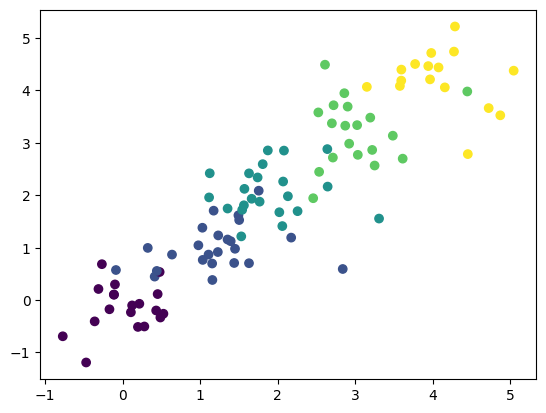

In [7]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:100, 0], X_train[:100, 1], c=y_train[:100]);

**Question 2.2.** Entraînez un [modèle de régression logistique](https://ml.dask.org/modules/generated/dask_ml.linear_model.LogisticRegression.html) et évaluez ses performances sur le jeu de test.

In [8]:
from dask_ml.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test).compute()

/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.10_ml/lib/python3.10/site-packages/dask_glm/utils.py:52: RuntimeWarning: overflow encountered in exp
  return np.exp(A)
/Users/rtavenar/py3.

0.2956012

**Question 2.3.** Il est également possible d'appliquer un modèle `scikit-learn` qui a déjà été appris à de nouvelles données stockées sous la forme de `dask.array`. Jetez un oeil à la documentation de la classe [`ParallelPostFit`](https://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html). Comment fonctionnent les estimateurs transformés par cette classe ?

_VOTRE RÉPONSE ICI._

**Question 2.4.** Testez le fonctionnement de cette classe dans le cas d'un classifieur SVM linéaire entraîné sur les données synthétiques `X_train, y_train` ci-dessous (de telle manière que l'entraînement ne prenne pas trop de temps) et des données de test telles que celles contenues dans `X_test`

In [9]:
from sklearn.svm import SVC

from sklearn.datasets import make_blobs
import numpy as np

from dask_ml.datasets import make_blobs as make_blobs_da
from dask_ml.wrappers import ParallelPostFit

centers = np.zeros((5, 10))
centers += np.arange(5)[:, None]

X_train, y_train = make_blobs(n_samples=100, 
                              n_features=10, 
                              centers=centers, 
                              cluster_std=.2)
X_test, y_test = make_blobs_da(n_samples=10 ** 7, 
                               n_features=10, 
                               centers=centers, 
                               cluster_std=.2,
                               chunks=10**5)

clf = SVC(kernel="linear", C=1.)
clf.fit(X_train, y_train)
clf_dml = ParallelPostFit(clf)

clf_dml.score(X_test, y_test)

1.0

## Exercice de synthèse

**Question.** Comparez, en termes de temps de calcul, un pipeline qui enchaînerait une standardisation des données, une ACP, et un clustering $k$-means, selon que les données sont stockées sous forme de `numpy.array` ou de `dask.array` et que vous utilisez les implémentations `scikit-learn` ou `daskML` des méthodes citées.

Pour cette étude, vous utiliserez un jeu de données synthétique et ferez évoluer la taille du jeu de données pour évaluer son impact sur le temps de calcul (le temps de génération du jeu de données ne devra pas être pris en compte dans le temps de calcul).

Pensez à supprimer votre client `dask` en exécutant la cellule ci-dessous (on suppose votre client est une variable nommée `client`).

In [10]:
del client